In [2]:
# Install if needed

try:
    from lightgbm import LGBMClassifier
except ImportError:
    !pip install lightgbm
    from lightgbm import LGBMClassifier


In [3]:
#PREPROCESSING

import csv
import math
import random

#Reads CSV, turns into list of dicts, max rows used for testing with sample size
def read_csv_as_dicts(path, max_rows=None):
    rows = []
    with open(path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            rows.append(row)
            if max_rows is not None and i + 1 >= max_rows:
                break
    return rows

#loads train_transaction and train_identity then merges them on TransactionID
#we do a left join so every transaction stays, even if identity info is missing
def load_and_merge_train_data(transaction_path, identity_path, max_rows=None):
    #first read identity table into a lookup dict keyed by TransactionID
    identity_lookup = {}

    with open(identity_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            tid = row.get("TransactionID")
            if tid is not None:
                identity_lookup[tid] = row

    merged_rows = []

    #now read transaction table and attach identity fields when they exist
    with open(transaction_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for i, trow in enumerate(reader):
            tid = trow.get("TransactionID")
            merged = dict(trow)  #start with transaction data

            #if there is a matching identity row, copy its fields in
            if tid in identity_lookup:
                id_row = identity_lookup[tid]
                for k, v in id_row.items():
                    if k == "TransactionID":
                        continue
                    #if same column exists in both, transaction wins
                    if k not in merged or merged[k] is None or merged[k] == "":
                        merged[k] = v

            merged_rows.append(merged)

            if max_rows is not None and i + 1 >= max_rows:
                break

    return merged_rows

#Train Validation split. Keeps the ratio of Fraud/Not Fraud equal in both train and val.
def train_val_split_stratified(X, y, val_ratio=0.2, seed=42):
    
    #using a fixed seed so the split stays the same if we rerun it
    random.seed(seed)

    #indexes of positive (fraud) and negative (non fraud) labels
    pos_idx = [i for i, v in enumerate(y) if v == 1]
    neg_idx = [i for i, v in enumerate(y) if v == 0]

    random.shuffle(pos_idx)
    random.shuffle(neg_idx)

    #decide how many of each group should end up in validation set
    n_pos_val = int(len(pos_idx) * val_ratio)
    n_neg_val = int(len(neg_idx) * val_ratio)

    #first chunk goes to validation, the rest goes to training
    val_idx = pos_idx[:n_pos_val] + neg_idx[:n_neg_val]
    train_idx = pos_idx[n_pos_val:] + neg_idx[n_neg_val:]

    random.shuffle(train_idx)
    random.shuffle(val_idx)

    #building the actual sets based on the index lists
    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]
    X_val   = [X[i] for i in val_idx]
    y_val   = [y[i] for i in val_idx]

    return X_train, y_train, X_val, y_val

#pulls isFraud column out as 0 or 1
def extract_labels(rows, label_col="isFraud"):
    labels = []
    for row in rows:
        v = row.get(label_col, "0")
        labels.append(int(float(v)))
    return labels


#creates day and hour features from TransactionDT
def add_time_features(rows, dt_col="TransactionDT"):
    for row in rows:
        raw = row.get(dt_col, "")
        try:
            dt = float(raw)
        except:
            dt = 0.0

        day = int(dt // 86400)
        hour = int((dt // 3600) % 24)

        row["day"]  = day
        row["hour"] = hour



#checks whether a string can be read as float
def can_parse_float(s):
    try:
        float(s)
        return True
    except:
        return False


#scans through all rows and collects stats for every column
def compute_column_stats(rows, max_unique_track=1000):
    stats = {}
    if not rows:
        return stats

    for row in rows:
        for col, v in row.items():

            #if we see a new column name for the first time, initialize its stats
            if col not in stats:
                stats[col] = {
                    "n_total": 0,
                    "n_missing": 0,
                    "n_numeric_like": 0,
                    "unique_values": set(),
                    "unique_capped": False
                }

            s = stats[col]
            s["n_total"] += 1

            if v is None or v == "":
                s["n_missing"] += 1
            else:
                #check if the value looks numeric
                if can_parse_float(v):
                    s["n_numeric_like"] += 1

                #track unique values until we hit the cap
                if not s["unique_capped"]:
                    s["unique_values"].add(v)
                    if len(s["unique_values"]) > max_unique_track:
                        s["unique_capped"] = True

    return stats



#based on stats we decide which columns are numeric and which are categorical
#we also drop columns with too much missingness or card that is way too high
def infer_num_cat_from_stats(stats, max_missing_frac=0.7, max_cat_cardinality=20,
                             label_col="isFraud", dt_col="TransactionDT"):

    numeric_cols = []
    cat_cols = []
    dropped_cols = []
    info_per_col = {}

    for col, s in stats.items():
        total = s["n_total"]
        missing = s["n_missing"]
        non_missing = total - missing
        numeric_like = s["n_numeric_like"]
        uniques = s["unique_values"]

        missing_frac = missing / total if total > 0 else 1.0

        info_per_col[col] = {
            "missing_frac": missing_frac,
            "n_unique": len(uniques),
            "numeric_ratio": numeric_like / non_missing if non_missing > 0 else 0.0
        }

        #skip isFraud and TransactionDT from becoming model features
        if col == label_col or col == dt_col:
            continue

        #drop if missingness too high
        if missing_frac > max_missing_frac:
            dropped_cols.append(col)
            continue

        #decide if column should be numeric or categorical
        is_numeric = info_per_col[col]["numeric_ratio"] >= 0.9

        if is_numeric:
            numeric_cols.append(col)
        else:
            #categorical but watch out for crazy cardinality
            if len(uniques) > max_cat_cardinality or s["unique_capped"]:
                dropped_cols.append(col)
            else:
                cat_cols.append(col)

    #make sure our engineered time columns count as numeric
    for t in ["day", "hour"]:
        if t in stats and t not in dropped_cols and t not in numeric_cols:
            numeric_cols.append(t)

    return numeric_cols, cat_cols, dropped_cols, info_per_col



#fill missing numeric values with median
def impute_numeric_median(rows, numeric_cols):
    medians = {}

    #compute median for each column
    for col in numeric_cols:
        vals = []
        for row in rows:
            v = row.get(col, None)
            if v is not None and v != "":
                vals.append(float(v))

        vals.sort()
        n = len(vals)
        if n == 0:
            medians[col] = 0.0
        elif n % 2 == 1:
            medians[col] = vals[n // 2]
        else:
            medians[col] = (vals[n // 2 - 1] + vals[n // 2]) / 2.0

    #apply imputation
    for row in rows:
        for col in numeric_cols:
            v = row.get(col, None)
            if v is None or v == "":
                row[col] = float(medians[col])
            else:
                row[col] = float(v)

    return medians



#categorical fields with blank values become "Missing"
def fill_categorical_missing(rows, cat_cols):
    for row in rows:
        for col in cat_cols:
            v = row.get(col, None)
            if v is None or v == "":
                row[col] = "Missing"



#decides which categories will get their own one hot column
def build_one_hot_mapping(rows, cat_cols, min_count=1):
    mapping = {}
    for col in cat_cols:
        counts = {}
        for row in rows:
            val = row[col]
            counts[val] = counts.get(val, 0) + 1

        #keep categories that occur enough times
        kept = [val for val, c in counts.items() if c >= min_count]
        kept.sort()
        mapping[col] = kept

    return mapping



#standardizing numeric columns so they’re on similar scales
def standardize_numeric(rows, numeric_cols):
    means = {}
    stds  = {}

    for col in numeric_cols:
        vals = [float(row[col]) for row in rows]
        n = len(vals)

        if n == 0:
            means[col] = 0.0
            stds[col] = 1.0
            continue

        m = sum(vals) / n
        var = sum((v - m) ** 2 for v in vals) / n
        s = math.sqrt(var) if var > 0 else 1.0

        means[col] = m
        stds[col] = s

        for row in rows:
            row[col] = (float(row[col]) - m) / s

    return means, stds



#turns all rows into a matrix X of floats
def rows_to_matrix(rows, numeric_cols, cat_cols, one_hot_map):
    one_hot_features = []
    for col in cat_cols:
        for cat in one_hot_map[col]:
            one_hot_features.append((col, cat))

    X = []
    for row in rows:
        feats = []

        for col in numeric_cols:
            feats.append(float(row[col]))

        for col, cat in one_hot_features:
            feats.append(1.0 if row[col] == cat else 0.0)

        X.append(feats)

    return X, one_hot_features


#runs the full preprocessing pipeline, uses all the helpers above
def preprocess_logreg(
     transaction_path,
    identity_path,
    max_rows=None,
    val_ratio=0.2,
    max_missing_frac=0.7,
    max_cat_cardinality=20,
    min_count_cat=50,
    verbose=True,
):
    #start by loading and merging the transaction and identity tables
    if verbose:
        print(f"Reading and merging data from {transaction_path} and {identity_path}...")

    rows = load_and_merge_train_data(transaction_path, identity_path, max_rows=max_rows)

    if verbose:
        print(f"Merged rows: {len(rows)}")

    #extract isFraud values so we have our labels
    y = extract_labels(rows, label_col="isFraud")

    #add day and hour columns from TransactionDT
    #this gives the model some rough time based patterns
    add_time_features(rows, dt_col="TransactionDT")

    #scan the entire dataset and gather stats for each column
    #this helps us decide which ones to keep or drop
    if verbose:
        print("Computing column stats so we know missingness and cardinality...")

    stats = compute_column_stats(rows)

    #based on the stats above, figure out which columns are numeric, which are categorical
    #and which ones should be dropped for being too messy or too sparse
    numeric_cols, cat_cols, dropped_cols, col_info = infer_num_cat_from_stats(
        stats,
        max_missing_frac=max_missing_frac,
        max_cat_cardinality=max_cat_cardinality,
        label_col="isFraud",
        dt_col="TransactionDT",
    )

    if verbose:
        print(f"Numeric columns selected: {len(numeric_cols)}")
        print(f"Categorical columns selected: {len(cat_cols)}")
        print(f"Dropped columns: {len(dropped_cols)}")

    #build a new version of rows keeping only the columns we actually want
    #plus the ones that were used earlier (isFraud, day, hour)
    keep_cols = set(numeric_cols + cat_cols)
    keep_cols.update(["isFraud", "TransactionDT", "day", "hour"])

    filtered_rows = []
    for row in rows:
        new_row = {}
        for c in keep_cols:
            if c in row:
                new_row[c] = row[c]
        filtered_rows.append(new_row)
    rows = filtered_rows

    #at this point rows only includes the columns we care about
    #now we fix missing numeric values by plugging in the column median
    medians = impute_numeric_median(rows, numeric_cols)

    #for categorical fields, blank or None becomes literal string "Missing"
    fill_categorical_missing(rows, cat_cols)

    #decide which categories get their own one hot column
    #we ignore categories that appear very rarely to avoid blowing up the feature count
    one_hot_map = build_one_hot_mapping(rows, cat_cols, min_count=min_count_cat)

    #numeric values have different scales so we standardize them
    #this helps logistic regression converge better
    means, stds = standardize_numeric(rows, numeric_cols)

    #finally turn the cleaned rows into a full numeric matrix X
    X, one_hot_features = rows_to_matrix(rows, numeric_cols, cat_cols, one_hot_map)

    #split into train and validation sets while keeping the fraud ratio balanced
    X_train, y_train, X_val, y_val = train_val_split_stratified(X, y, val_ratio=val_ratio)

    if verbose:
        print(f"Train size: {len(X_train)}")
        print(f"Validation size: {len(X_val)}")
        if len(X_train) > 0:
            print(f"Total features per row: {len(X_train[0])}")

    #return everything needed for modeling and analysis
    metadata = {
        "numeric_cols": numeric_cols,
        "cat_cols": cat_cols,
        "dropped_cols": dropped_cols,
        "col_info": col_info,
        "medians": medians,
        "means": means,
        "stds": stds,
        "one_hot_map": one_hot_map,
        "one_hot_features": one_hot_features,
    }

    return X_train, y_train, X_val, y_val, metadata


In [4]:

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, num_epochs=100, lambda_l2=0.0, verbose=True):
        #setting hyperparameters
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.lambda_l2 = lambda_l2
        self.verbose = verbose

        #weights and bias will be filled in after we know number of features
        self.w = None
        self.b = 0.0

        #these help counter the huge imbalance
        self.class_weight_pos = 1.0
        self.class_weight_neg = 1.0

    #sigmoid function turns any real number into a probability from 0 to 1
    def _sigmoid(self, z):
        #clip extreme values so exp() doesnt blow up
        if z < -500:
            z = -500
        elif z > 500:
            z = 500
        return 1.0 / (1.0 + math.exp(-z))

    #calculate class weights so fraud samples get more influence during training
    def _compute_class_weights(self, y):
        n = len(y)
        num_pos = sum(1 for v in y if v == 1)
        num_neg = n - num_pos

        #avoiding division by zero just in case
        if num_pos == 0:
            self.class_weight_pos = 1.0
        else:
            self.class_weight_pos = n / (2.0 * num_pos)

        if num_neg == 0:
            self.class_weight_neg = 1.0
        else:
            self.class_weight_neg = n / (2.0 * num_neg)

    #main training loop
    def fit(self, X, y):
        n_samples = len(X)
        if n_samples == 0:
            raise ValueError("Training data is empty")

        #each row has same number of features
        n_features = len(X[0])

        #initializing weights to zero so we start from a neutral point
        self.w = [0.0] * n_features
        self.b = 0.0

        #set up class-specific weighting based on imbalance
        self._compute_class_weights(y)

        #run gradient descent for a number of epochs
        for epoch in range(1, self.num_epochs + 1):
            total_loss = 0.0
            grad_w = [0.0] * n_features
            grad_b = 0.0

            #looping through the dataset once per epoch
            for i in range(n_samples):
                xi = X[i]
                yi = y[i]

                #compute raw model output (linear part)
                z = self.b
                for j in range(n_features):
                    z += self.w[j] * xi[j]

                #turn into probability of fraud
                p = self._sigmoid(z)

                #pick the right weight depending on whether sample is fraud or not
                cw = self.class_weight_pos if yi == 1 else self.class_weight_neg

                #avoid log(0) by clipping probability a tiny bit
                eps = 1e-15
                p_clip = min(max(p, eps), 1.0 - eps)

                #cross entropy loss for this sample
                loss_i = -(yi * math.log(p_clip) + (1 - yi) * math.log(1 - p_clip))
                total_loss += cw * loss_i

                #error is how far off our prediction is
                error = p - yi
                weighted_error = cw * error

                #accumulate gradients
                for j in range(n_features):
                    grad_w[j] += weighted_error * xi[j]

                grad_b += weighted_error

            #average gradients over whole dataset
            total_loss = total_loss / n_samples
            for j in range(n_features):
                grad_w[j] = grad_w[j] / n_samples
            grad_b = grad_b / n_samples

            #L2 regularization adds penalty to big weights to prevent overfitting
            if self.lambda_l2 > 0.0:
                l2_penalty = 0.0
                for j in range(n_features):
                    l2_penalty += self.w[j] * self.w[j]

                l2_penalty *= (self.lambda_l2 / 2.0)
                total_loss += l2_penalty

                #gradient of L2 is lambda * w
                for j in range(n_features):
                    grad_w[j] += self.lambda_l2 * self.w[j]

            #gradient descent update step
            for j in range(n_features):
                self.w[j] -= self.learning_rate * grad_w[j]

            self.b -= self.learning_rate * grad_b

            #print loss occasionally so we know it's training
            if self.verbose and (epoch == 1 or epoch % 10 == 0 or epoch == self.num_epochs):
                print(f"Epoch {epoch}  Loss: {total_loss:.4f}")

    #turns a feature matrix into probabilities
    def predict_proba(self, X):
        if self.w is None:
            raise ValueError("Model has not been trained yet")

        probs = []
        for xi in X:
            z = self.b
            for j in range(len(self.w)):
                z += self.w[j] * xi[j]

            p = self._sigmoid(z)
            probs.append(p)

        return probs

    #turn probabilities into 0 or 1 classes
    #threshold is default 0.5 but can be changed if we care more about catching fraud
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        preds = []
        for p in probs:
            if p >= threshold:
                preds.append(1)
            else:
                preds.append(0)
        return preds


In [5]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import time

# accuracy metric, just to see how many labels we got correct
def accuracy_score(y_true, y_pred):
    correct = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct += 1
    return correct / len(y_true) if len(y_true) > 0 else 0.0


#ROC AUC calculation
#this uses a standard rank based formula 
def roc_auc_score_manual(y_true, y_scores):
    #pair up scores and labels then sort by score
    pairs = list(zip(y_scores, y_true))
    pairs.sort(key=lambda x: x[0])

    n_pos = sum(1 for _, label in pairs if label == 1)
    n_neg = sum(1 for _, label in pairs if label == 0)

    #if we only have one class in labels, AUC is not really defined
    if n_pos == 0 or n_neg == 0:
        return None

    #sum of ranks for all positive samples
    #ranks are 1 based here
    rank_sum_pos = 0.0
    for idx, (_, label) in enumerate(pairs, start=1):
        if label == 1:
            rank_sum_pos += idx

    #classic AUC formula using rank statistics
    auc = (rank_sum_pos - n_pos * (n_pos + 1) / 2.0) / (n_pos * n_neg)
    return auc


def evaluate_model(name, y_true, y_scores, threshold=0.5):
    #cutoff predictions
    y_pred = [1 if p >= threshold else 0 for p in y_scores]

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score_manual(y_true, y_scores)

    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    if auc is not None and not math.isnan(auc):
        print(f"  ROC AUC: {auc:.4f}")
    else:
        print("  ROC AUC: undefined (only one class)")
    print()

    return acc, auc


def main():
    #paths to the original kaggle files
    transaction_path = "../data/raw/train_transaction.csv"
    identity_path    = "../data/raw/train_identity.csv"

    #max_rows for testing, set to None for full dataset (This peaked at around 18GB RAM )
    #max_rows = 50000
    max_rows = None

    print("Starting preprocessing step")

    X_train, y_train, X_val, y_val, meta = preprocess_logreg(
        transaction_path=transaction_path,
        identity_path=identity_path,
        max_rows=max_rows,
        val_ratio=0.2,
        max_missing_frac=0.7,  #drop columns with more than 70 percent missing values
        max_cat_cardinality=20,  #drop categoricals with more than 20 unique categories
        min_count_cat=50,   #only one hot categories that appear at least 50 times
        verbose=True
    )

    print("Finished preprocessing")
    print()
    
    
    scratch_model = LogisticRegressionScratch(
        learning_rate=0.05,
        num_epochs=100,
        lambda_l2=0.001,
        verbose=True
    )
    print("Training scratch logistic regression")
    start = time.time()
    scratch_model.fit(X_train, y_train)
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")
    scratch_probs = scratch_model.predict_proba(X_val)
    print()
    
    
    rf = RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )
    print("Training RandomForestClassifier")
    start = time.time()
    rf.fit(X_train, y_train)
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")
    rf_probs = rf.predict_proba(X_val)[:, 1]
    print()
    
    
    hgb = HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_iter=200,
        class_weight="balanced",
        max_leaf_nodes=31,
        min_samples_leaf=50,
        
    )
    print("Training HistGradientBoostingClassifier")
    start = time.time()
    hgb.fit(X_train, y_train)
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")
    hgb_probs = hgb.predict_proba(X_val)[:, 1]
    print()
    
    
    lgbm = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.03,
        class_weight="balanced",
        objective="binary",
        n_jobs=-1,
        random_state=42
        
    )
    print("Training LightGBM")
    start = time.time()
    lgbm.fit(X_train, y_train)
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")
    lgbm_probs = lgbm.predict_proba(X_val)[:, 1]
    print()
    
    
    
    print("Model comparison")
    results = {}
    results["Scratch Logistic Regression"] = evaluate_model(
        "Scratch Logistic Regression", y_val, scratch_probs
    )
    results["RandomForest"] = evaluate_model(
        "RandomForest", y_val, rf_probs
    )
    results["HistGradientBoosting"] = evaluate_model(
        "HistGradientBoosting", y_val, hgb_probs
    )
    results["LightGBM"] = evaluate_model(
        "LightGBM", y_val, lgbm_probs
    )
    
    print("Summary (acc, auc):")
    for name, (acc, auc) in results.items():
        print(f"{name:24s} -> acc={acc:.4f}, auc={auc:.4f}")

    return results, y_val, scratch_probs, rf_probs, hgb_probs, lgbm_probs

if __name__ == "__main__":
    results, y_val, scratch_probs, rf_probs, hgb_probs, lgbm_probs = main()

Starting preprocessing step
Reading and merging data from ../data/raw/train_transaction.csv and ../data/raw/train_identity.csv...
Merged rows: 590540
Computing column stats so we know missingness and cardinality...
Numeric columns selected: 229
Categorical columns selected: 23
Dropped columns: 182
Train size: 472433
Validation size: 118107
Total features per row: 304
Finished preprocessing

Training scratch logistic regression
Epoch 1  Loss: 0.6931
Epoch 10  Loss: 0.5603
Epoch 20  Loss: 0.5426
Epoch 30  Loss: 0.5346
Epoch 40  Loss: 0.5296
Epoch 50  Loss: 0.5258
Epoch 60  Loss: 0.5227
Epoch 70  Loss: 0.5202
Epoch 80  Loss: 0.5180
Epoch 90  Loss: 0.5161
Epoch 100  Loss: 0.5145
Training time: 1972.27 seconds

Training RandomForestClassifier
Training time: 296.29 seconds

Training HistGradientBoostingClassifier
Training time: 99.11 seconds

Training LightGBM
[LightGBM] [Info] Number of positive: 16531, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the

C:\Users\domen\Miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Model comparison
Scratch Logistic Regression:
  Accuracy: 0.7580
  ROC AUC: 0.8236

RandomForest:
  Accuracy: 0.9791
  ROC AUC: 0.9422

HistGradientBoosting:
  Accuracy: 0.8851
  ROC AUC: 0.9296

LightGBM:
  Accuracy: 0.8961
  ROC AUC: 0.9365

Summary (acc, auc):
Scratch Logistic Regression -> acc=0.7580, auc=0.8236
RandomForest             -> acc=0.9791, auc=0.9422
HistGradientBoosting     -> acc=0.8851, auc=0.9296
LightGBM                 -> acc=0.8961, auc=0.9365


In [6]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix
import pandas as pd

model_names = ["Scratch LR", "RandomForest", "HistGradientBoosting", "LightGBM"]

#AUC vals from the results
auc_values = [
    results["Scratch Logistic Regression"][1],
    results["RandomForest"][1],
    results["HistGradientBoosting"][1],
    results["LightGBM"][1],
]



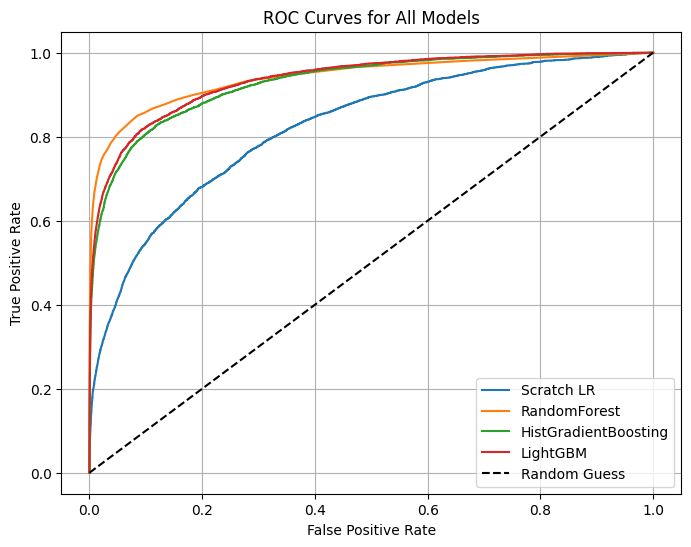

In [7]:
plt.figure(figsize=(8, 6))

score_lists = [scratch_probs, rf_probs, hgb_probs, lgbm_probs]

for name, scores in zip(model_names, score_lists):
    fpr, tpr, _ = roc_curve(y_val, scores)
    plt.plot(fpr, tpr, label=name)

#diagonal line = random guessing
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()


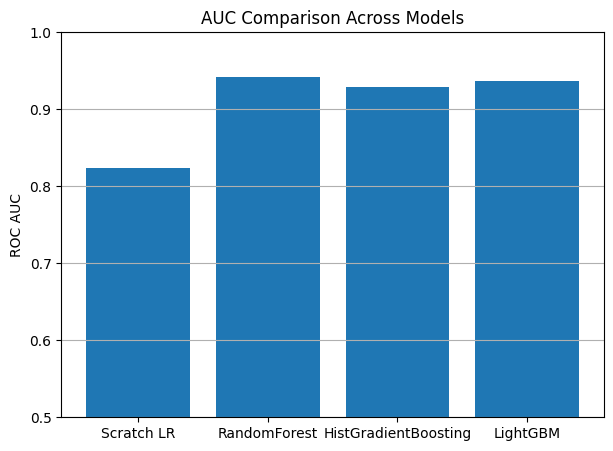

In [8]:
plt.figure(figsize=(7, 5))
plt.bar(model_names, auc_values)
plt.ylabel("ROC AUC")
plt.title("AUC Comparison Across Models")
plt.ylim(0.5, 1.0)
plt.grid(axis="y")
plt.show()


In [9]:
df_results = pd.DataFrame({
    "Model": model_names,
    "Accuracy": [
        results["Scratch Logistic Regression"][0],
        results["RandomForest"][0],
        results["HistGradientBoosting"][0],
        results["LightGBM"][0],
    ],
    "AUC": auc_values,
})

df_results


,Model,Accuracy,AUC
0,Scratch LR,0.757982,0.823604
1,RandomForest,0.979146,0.942209
2,HistGradientBoosting,0.885113,0.929555
3,LightGBM,0.896145,0.936527


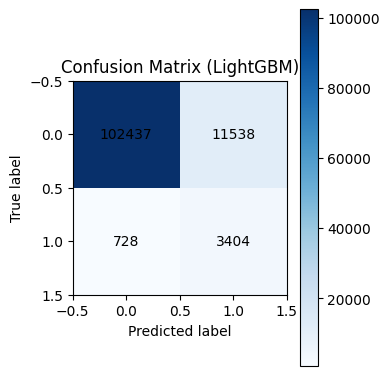

In [ ]:
#turn probabilities into labels at threshold 0.5
lgbm_pred_labels = [1 if p >= 0.5 else 0 for p in lgbm_probs]

cm = confusion_matrix(y_val, lgbm_pred_labels)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (LightGBM)")
plt.xlabel("Predicted label")
plt.ylabel("True label")

#annotate the cells with counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center", color="black")

plt.colorbar()
plt.tight_layout()
plt.show()
